# Variance-Weighted Representativeness Score (VWRS)

This notebook demonstrates:
1. The new VWRS formula that accounts for sampling variance
2. Optimal sample allocation using Neyman allocation
3. Comparison with traditional GRI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')

from gri.variance_weighted import calculate_vwrs, optimal_allocation, compare_gri_vwrs

## Example 1: Simple Demographic Distribution

Let's consider a hypothetical survey trying to represent 5 countries with very different population sizes.

In [2]:
# Define population proportions (true global distribution)
population_proportions = {
    'China': 0.18,      # 18% of global population
    'India': 0.17,      # 17%
    'USA': 0.04,        # 4%
    'Denmark': 0.001,   # 0.1%
    'Luxembourg': 0.0001 # 0.01%
}

# Normalize to ensure they sum to 1 for this example
total = sum(population_proportions.values())
population_proportions = {k: v/total for k, v in population_proportions.items()}

print("Population Proportions:")
for country, prop in population_proportions.items():
    print(f"{country}: {prop:.4f} ({prop*100:.2f}%)")

Population Proportions:
China: 0.4602 (46.02%)
India: 0.4347 (43.47%)
USA: 0.1023 (10.23%)
Denmark: 0.0026 (0.26%)
Luxembourg: 0.0003 (0.03%)


## Example Survey Sample

Let's say we collected 1000 responses with this distribution:

In [3]:
# Actual survey sample
sample_sizes = {
    'China': 150,      # Underrepresented (15% vs 18%)
    'India': 140,      # Underrepresented (14% vs 17%)
    'USA': 60,         # Overrepresented (6% vs 4%)
    'Denmark': 5,      # Overrepresented (0.5% vs 0.1%)
    'Luxembourg': 0    # Not represented at all!
}

total_sample = sum(sample_sizes.values())
sample_proportions = {k: v/total_sample for k, v in sample_sizes.items()}

print(f"Total sample size: {total_sample}")
print("\nSample Distribution:")
for country in population_proportions:
    n = sample_sizes.get(country, 0)
    p = sample_proportions.get(country, 0)
    print(f"{country}: n={n}, proportion={p:.4f} ({p*100:.2f}%)")

Total sample size: 355

Sample Distribution:
China: n=150, proportion=0.4225 (42.25%)
India: n=140, proportion=0.3944 (39.44%)
USA: n=60, proportion=0.1690 (16.90%)
Denmark: n=5, proportion=0.0141 (1.41%)
Luxembourg: n=0, proportion=0.0000 (0.00%)


## Calculate Traditional GRI vs VWRS

In [4]:
# Traditional GRI
gri = 0
for country in population_proportions:
    p_i = sample_proportions.get(country, 0)
    pi_i = population_proportions[country]
    gri += 0.5 * abs(p_i - pi_i)
gri = 1 - gri

# VWRS
vwrs = calculate_vwrs(sample_proportions, population_proportions, sample_sizes)

print(f"Traditional GRI: {gri:.4f}")
print(f"Variance-Weighted Score (VWRS): {vwrs:.4f}")
print(f"\nVWRS is {'higher' if vwrs > gri else 'lower'} than GRI")

Traditional GRI: 0.9217
Variance-Weighted Score (VWRS): 0.9581

VWRS is higher than GRI


## Detailed Breakdown by Country

In [5]:
# Create detailed comparison
details = []
total_weight = 0

for country in population_proportions:
    p_i = sample_proportions.get(country, 0)
    pi_i = population_proportions[country]
    n_i = sample_sizes.get(country, 0)
    
    # Standard error
    if n_i > 0:
        se_i = np.sqrt(p_i * (1 - p_i) / n_i)
    else:
        se_i = 1.0
    
    # Weight for VWRS
    weight = pi_i * se_i
    total_weight += weight
    
    details.append({
        'Country': country,
        'Pop %': pi_i * 100,
        'Sample %': p_i * 100,
        'n': n_i,
        'SE': se_i,
        'Abs Dev': abs(p_i - pi_i),
        'GRI Impact': 0.5 * abs(p_i - pi_i),
        'VWRS Weight': weight
    })

details_df = pd.DataFrame(details)
details_df['Normalized Weight'] = details_df['VWRS Weight'] / total_weight
details_df = details_df.round(4)

print(details_df.to_string(index=False))

   Country   Pop %  Sample %   n     SE  Abs Dev  GRI Impact  VWRS Weight  Normalized Weight
     China 46.0240   42.2535 150 0.0403   0.0377      0.0189       0.0186             0.4435
     India 43.4671   39.4366 140 0.0413   0.0403      0.0202       0.0180             0.4290
       USA 10.2276   16.9014  60 0.0484   0.0667      0.0334       0.0049             0.1182
   Denmark  0.2557    1.4085   5 0.0527   0.0115      0.0058       0.0001             0.0032
Luxembourg  0.0256    0.0000   0 1.0000   0.0003      0.0001       0.0003             0.0061


## Optimal Sample Allocation

What would be the optimal way to allocate 1000 survey responses?

Sample Allocation Comparison (n=1000):
   Country  Population %  Proportional n  Optimal n  Actual n
     China     46.024035             460        460       150
     India     43.467144             434        435       140
       USA     10.227563             102        102        60
   Denmark      0.255689               2          3         5
Luxembourg      0.025569               0          0         0


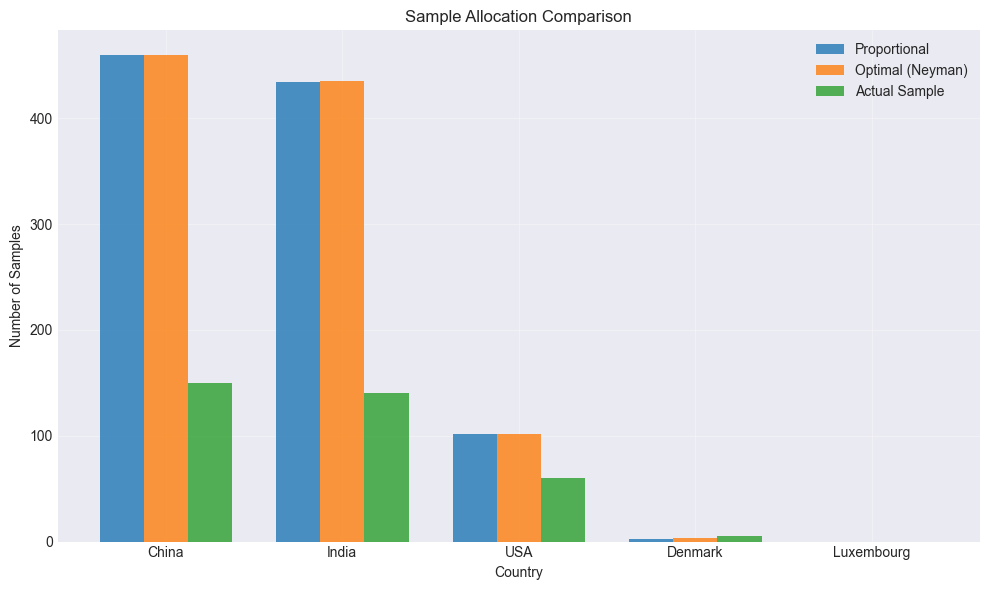

In [6]:
# Calculate optimal allocation
optimal = optimal_allocation(population_proportions, 1000)

# Compare with proportional allocation
proportional = {k: int(1000 * v) for k, v in population_proportions.items()}

comparison = pd.DataFrame({
    'Country': list(population_proportions.keys()),
    'Population %': [v*100 for v in population_proportions.values()],
    'Proportional n': [proportional[k] for k in population_proportions],
    'Optimal n': [optimal[k] for k in population_proportions],
    'Actual n': [sample_sizes.get(k, 0) for k in population_proportions]
})

print("Sample Allocation Comparison (n=1000):")
print(comparison.to_string(index=False))

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(len(comparison))
width = 0.25

ax.bar(x - width, comparison['Proportional n'], width, label='Proportional', alpha=0.8)
ax.bar(x, comparison['Optimal n'], width, label='Optimal (Neyman)', alpha=0.8)
ax.bar(x + width, comparison['Actual n'], width, label='Actual Sample', alpha=0.8)

ax.set_xlabel('Country')
ax.set_ylabel('Number of Samples')
ax.set_title('Sample Allocation Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Country'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Insights

1. **VWRS vs GRI**: VWRS gives less penalty to deviations in small demographics because we acknowledge the high sampling variance

2. **Optimal Allocation**: Notice that optimal allocation gives more samples to smaller countries than pure proportional allocation. This is because:
   - Each additional sample in a small demographic reduces variance more
   - We achieve "saturation" in large demographics more quickly

3. **Practical Implications**: 
   - Don't obsess over perfect proportional representation
   - Oversample small demographics for better overall reliability
   - Use VWRS to better assess true representativeness

## Interactive Example: Effect of Sample Size

Let's see how VWRS and GRI diverge as we change the sample size for small demographics:

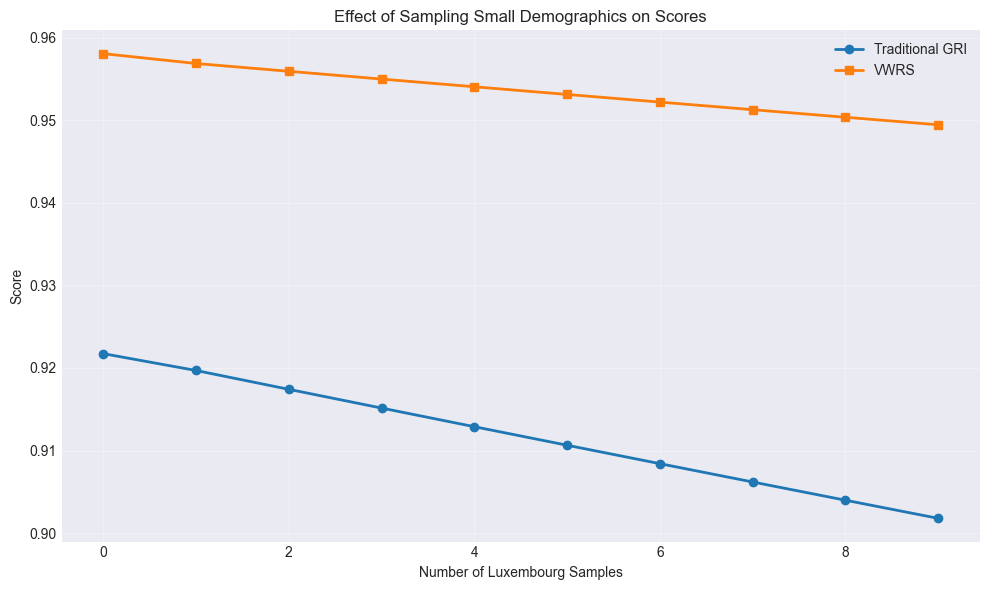

Score differences:
n=0: GRI=0.9217, VWRS=0.9581, Diff=+0.0363
n=1: GRI=0.9197, VWRS=0.9569, Diff=+0.0372
n=2: GRI=0.9174, VWRS=0.9559, Diff=+0.0385
n=3: GRI=0.9151, VWRS=0.9550, Diff=+0.0398
n=4: GRI=0.9129, VWRS=0.9540, Diff=+0.0412
n=5: GRI=0.9106, VWRS=0.9531, Diff=+0.0425
n=6: GRI=0.9084, VWRS=0.9522, Diff=+0.0438
n=7: GRI=0.9062, VWRS=0.9513, Diff=+0.0451
n=8: GRI=0.9040, VWRS=0.9504, Diff=+0.0464
n=9: GRI=0.9018, VWRS=0.9494, Diff=+0.0477


In [7]:
# Test different sample sizes for Luxembourg
lux_samples = range(0, 10)
gri_scores = []
vwrs_scores = []

for n_lux in lux_samples:
    # Update sample
    test_sizes = sample_sizes.copy()
    test_sizes['Luxembourg'] = n_lux
    
    test_total = sum(test_sizes.values())
    test_proportions = {k: v/test_total for k, v in test_sizes.items()}
    
    # Calculate scores
    gri = 1 - sum(0.5 * abs(test_proportions.get(k, 0) - population_proportions[k]) 
                  for k in population_proportions)
    vwrs = calculate_vwrs(test_proportions, population_proportions, test_sizes)
    
    gri_scores.append(gri)
    vwrs_scores.append(vwrs)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lux_samples, gri_scores, 'o-', label='Traditional GRI', linewidth=2)
plt.plot(lux_samples, vwrs_scores, 's-', label='VWRS', linewidth=2)
plt.xlabel('Number of Luxembourg Samples')
plt.ylabel('Score')
plt.title('Effect of Sampling Small Demographics on Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Score differences:")
for i, n in enumerate(lux_samples):
    diff = vwrs_scores[i] - gri_scores[i]
    print(f"n={n}: GRI={gri_scores[i]:.4f}, VWRS={vwrs_scores[i]:.4f}, Diff={diff:+.4f}")